In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('drive/MyDrive/NLP_Project/archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

drive/MyDrive/NLP_Project/archive/twitter_training.csv
drive/MyDrive/NLP_Project/archive/twitter_validation.csv


In [ ]:
import torch
import re
from tqdm.notebook import tqdm
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
test_df = pd.read_csv('drive/MyDrive/NLP_Project/archive/twitter_validation.csv', header=None)
train_df = pd.read_csv('drive/MyDrive/NLP_Project/archive/twitter_training.csv', header=None)

test_df.reset_index(drop=True,inplace=True)
train_df.reset_index(drop=True,inplace=True)

df = pd.concat([train_df,test_df], axis=0)
df.drop([0], axis=1, inplace=True)
df.columns = ['platform','sentiment','text']

In [ ]:
df.drop(['platform'], axis=1, inplace=True)
df.sentiment = df.sentiment.map({"Neutral":0, "Irrelevant":0 ,"Positive":1,"Negative":2})
df.dropna(inplace=True)

In [ ]:
# def clean_text(text):
#     if isinstance(text, str):
#         # Remove numbers
#         text = re.sub(r'\d+', '', text)

#         # Remove special characters
#         str_text = re.sub(r'[^\w\s]', '', text)

#         # Remove stop words
#         stop_words = set(stopwords.words('english'))
#         tokens = str_text.lower().split()
#         str_text = ' '.join([word for word in tokens if word not in stop_words])
#         return str_text
#     else:
#         return text

def clean_text(text):
    if isinstance(text, str):
        # Remove numbers
        text = re.sub(r'\d+', '', text)

        # Do not remove special characters
        # str_text = re.sub(r'[^\w\s]', '', text) <- This line was removed to keep special characters

        # Remove stop words
        stop_words = set(stopwords.words('english'))
        tokens = text.lower().split()
        str_text = ' '.join([word for word in tokens if word not in stop_words])
        # str_text = ' '.join([word for word in tokens])
        return str_text
    else:
        return text

In [ ]:
df["text"] = df['text'].apply(clean_text)

In [ ]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                         do_lower_case = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(df,test_size = 0.2, stratify = df.sentiment.values)

In [ ]:
import gc
del df
gc.collect()

30

In [ ]:
train_df

,sentiment,text
70356,0,enjoying last bits terminator live event. . .
68094,1,we're excited @cdprojektred's upcoming cyberpu...
56896,0,laggy flick shot. check channel here. twitch.t...
38756,2,call now: new yogi saron hot stone meta people...
3311,1,discuss enough clear already stinky mw mp
...,...,...
29332,0,"fuck it, stream going crazy goddamn day.."
62416,0,vehicle comet sports car - grand theft auto
1080,0,honor joy part borderlands theater tucson prod...
68366,1,"time, despite fact currently million people li..."


In [ ]:
encoder_train = tokenizer.batch_encode_plus(train_df.text.values,
                                           add_special_tokens = True,
                                            return_attention_mask = True,
                                           pad_to_max_length = True,
                                           max_length = 256,
                                           return_tensors = 'pt')



encoder_test = tokenizer.batch_encode_plus(test_df.text.values,
                                           add_special_tokens = True,
                                            return_attention_mask = True,
                                           pad_to_max_length = True,
                                           max_length = 256,
                                           return_tensors = 'pt')

input_ids_train = encoder_train['input_ids']
attention_masks_train = encoder_train["attention_mask"]
labels_train = torch.tensor(train_df.sentiment.values)


input_ids_test = encoder_test['input_ids']
attention_masks_test = encoder_test["attention_mask"]
labels_test = torch.tensor(test_df.sentiment.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
data_train = TensorDataset(input_ids_train,attention_masks_train,labels_train)
data_test = TensorDataset(input_ids_test,attention_masks_test,labels_test)

In [ ]:
len(data_train),len(data_test)

(59996, 15000)

In [ ]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                     num_labels = 3,
                                     output_attentions = False,
                                     output_hidden_states =  False)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Load from pretrain model
import torch
from transformers import BertForSequenceClassification, BertConfig
config = BertConfig.from_pretrained('bert-base-uncased',
                                    num_labels=3,
                                    output_attentions=False,
                                    output_hidden_states=False)

model = BertForSequenceClassification(config)
model_path = 'drive/MyDrive/NLP_Project/bert_base_model.pth'
model.bert.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
from torch.utils.data import RandomSampler,SequentialSampler,DataLoader
dataloader_train = DataLoader(
    data_train,
    sampler= RandomSampler(data_train),
    batch_size = 16

)


dataloader_test = DataLoader(
    data_test,
    sampler= RandomSampler(data_test),
    batch_size = 32

)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

def f1_score_func(preds,labels):
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat,preds_flat,average = 'weighted')

def acc(preds,labels):
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Loading:{device}")
model

Loading:cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# for name, param in model.named_parameters():
#     if any(name.startswith(f"bert.encoder.layer.{i}") for i in range(11)):
#         param.requires_grad = False

# for name, param in model.named_parameters():
#     if name.startswith("bert.encoder.layer.11"):
#         param.requires_grad = False

for name, param in model.named_parameters():
     print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight True
bert.embeddings.position_embeddings.weight True
bert.embeddings.token_type_embeddings.weight True
bert.embeddings.LayerNorm.weight True
bert.embeddings.LayerNorm.bias True
bert.encoder.layer.0.attention.self.query.weight True
bert.encoder.layer.0.attention.self.query.bias True
bert.encoder.layer.0.attention.self.key.weight True
bert.encoder.layer.0.attention.self.key.bias True
bert.encoder.layer.0.attention.self.value.weight True
bert.encoder.layer.0.attention.self.value.bias True
bert.encoder.layer.0.attention.output.dense.weight True
bert.encoder.layer.0.attention.output.dense.bias True
bert.encoder.layer.0.attention.output.LayerNorm.weight True
bert.encoder.layer.0.attention.output.LayerNorm.bias True
bert.encoder.layer.0.intermediate.dense.weight True
bert.encoder.layer.0.intermediate.dense.bias True
bert.encoder.layer.0.output.dense.weight True
bert.encoder.layer.0.output.dense.bias True
bert.encoder.layer.0.output.LayerNorm.weight True


In [ ]:
def evaluate(dataloader_val):
    model.eval()

    loss_val_total = 0
    predictions,true_vals = [],[]

    for batch in tqdm(dataloader_val):
        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':  batch[0],
                  'attention_mask':batch[1],
                  'labels': batch[2]
                 }
        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total +=loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)


    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 5
total_steps = len(dataloader_train) * epochs

warmup_steps = total_steps * 0.1

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
training_loss = []
validation_loss = []
testScore = []
test_acc = []
for epoch in tqdm(range(1,epochs+1)):
    model.train()

    loss_train_total=0

    progress_bar = tqdm(dataloader_train,desc = "Epoch: {:1d}".format(epoch),leave = False,disable = False)


    for batch in progress_bar:
        train_acc = 0.0
        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {
            "input_ids":batch[0],
            "attention_mask":batch[1],
            "labels":batch[2]

        }
        outputs = model(**inputs)

        loss = outputs[0]
#         logits = outputs[1]
        loss_train_total +=loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(),1.0)

        optimizer.step()
        scheduler.step()


        progress_bar.set_postfix({'training_loss':'{:.3f}'.format(loss.item()/len(batch))})

    tqdm.write(f'Epoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    training_loss.append(loss_train_avg)
    tqdm.write(f'Training Loss: {loss_train_avg}')
    val_loss,predictions,true_vals = evaluate(dataloader_test)
    test_score = f1_score_func(predictions,true_vals)
    test_accuracy = acc(predictions, true_vals)
    validation_loss.append(val_loss)
    testScore.append(test_score)
    test_acc.append(test_accuracy)
    tqdm.write(f'Val Loss:{val_loss}\n Test Score:{test_score} \n Test Accuracy:{test_accuracy}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

<ipython-input-46-26550d2252a7>:31: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)


Epoch 1
Training Loss: 0.7711055962363879


  0%|          | 0/469 [00:00<?, ?it/s]

Val Loss:0.510668596161454
 Test Score:0.8003976333534468 
 Test Accuracy:0.8008


Epoch: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

<ipython-input-46-26550d2252a7>:31: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)


Epoch 2
Training Loss: 0.35751887963960566


  0%|          | 0/469 [00:00<?, ?it/s]

Val Loss:0.31612478028228286
 Test Score:0.8901735732047081 
 Test Accuracy:0.8902666666666667


Epoch: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

<ipython-input-46-26550d2252a7>:31: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)


Epoch 3
Training Loss: 0.18328696685161752


  0%|          | 0/469 [00:00<?, ?it/s]

Val Loss:0.3623549321796427
 Test Score:0.9119251106562838 
 Test Accuracy:0.9122


Epoch: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

<ipython-input-46-26550d2252a7>:31: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)


Epoch 4
Training Loss: 0.11390629841587506


  0%|          | 0/469 [00:00<?, ?it/s]

Val Loss:0.3475934316084332
 Test Score:0.92467501893588 
 Test Accuracy:0.9247333333333333


Epoch: 5:   0%|          | 0/3750 [00:00<?, ?it/s]

<ipython-input-46-26550d2252a7>:31: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)


Epoch 5
Training Loss: 0.07779881163389654


  0%|          | 0/469 [00:00<?, ?it/s]

Val Loss:0.35015524564490125
 Test Score:0.9308804851969047 
 Test Accuracy:0.9309333333333333


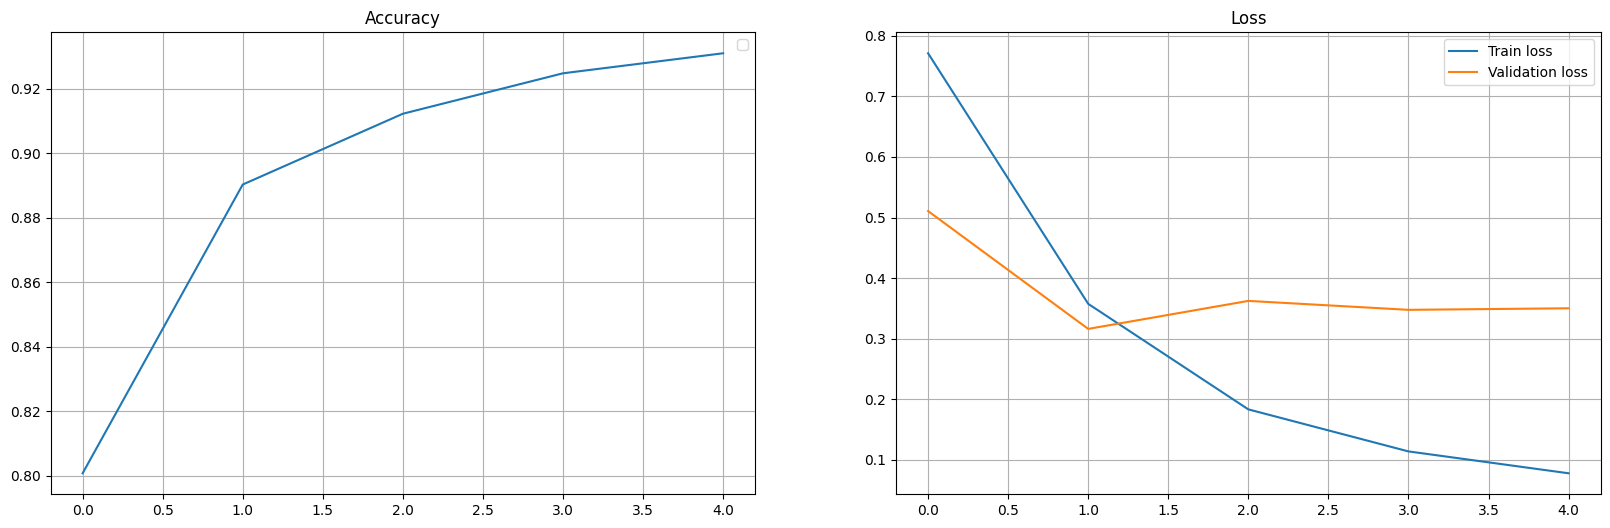

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(test_acc)
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Train loss')
plt.plot(validation_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

def evaluate_metrics(predictions, true_vals):
    accuracy = accuracy_score(true_vals, predictions)
    recall = recall_score(true_vals, predictions, average='macro')
    f1 = f1_score(true_vals, predictions, average='macro')

    return accuracy, recall, f1

model.eval()
with torch.no_grad():
    predictions = []
    true_labels = []

    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            "input_ids": batch[0],
            "attention_mask": batch[1]
        }

        outputs = model(**inputs)
        logits = outputs[0]
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        label_ids = batch[2].cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(label_ids)


accuracy, recall, f1 = evaluate_metrics(predictions, true_labels)
print(f"Test Accuracy: {accuracy}")
print(f"Test Recall: {recall}")
print(f"Test F1 Score: {f1}")


Test Accuracy: 0.9309333333333333
Test Recall: 0.9276434326369817
Test F1 Score: 0.9300679265762928


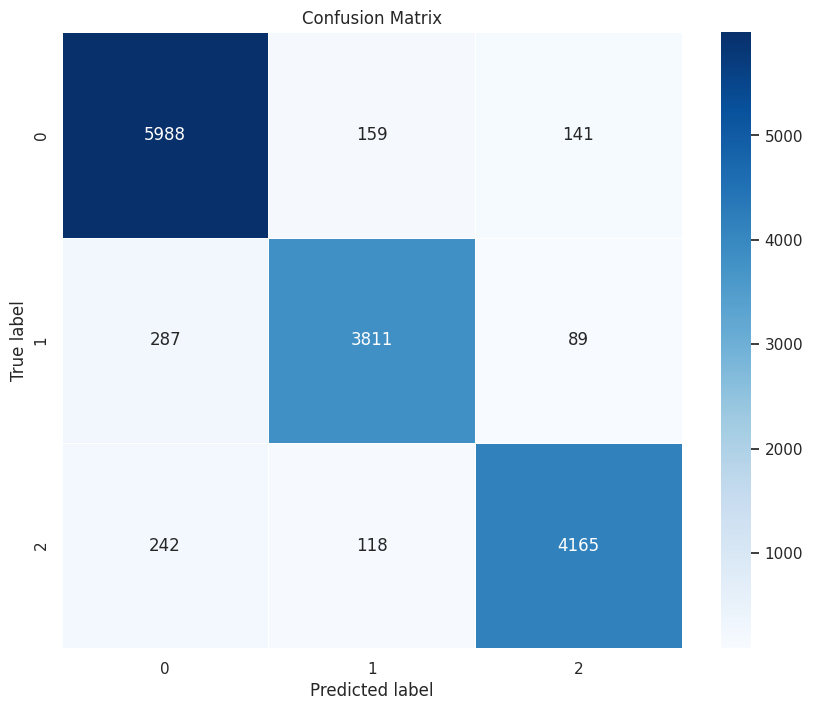

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

conf_matrix = confusion_matrix(true_labels, predictions)
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=.5)

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

In [ ]:
# model_save_path = 'drive/MyDrive/NLP_Project/'
# model_save_full_path = os.path.join(model_save_path, 'bert_9306.pth')
# torch.save(model.bert.state_dict(), model_save_full_path)